In [125]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_info_columns', 500)

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [126]:
## Load and pre-process data

#Load Main Dataframe
df = pd.read_csv('diabetic_data.csv'
                ,sep = ','
                ,na_values = '?')
"""
Create subset of dataframe keeping the first encounter provided for each 'patient_nbr' value. This keeps the rows with
the lowest index value and the lowest encounter ID value. This is build on the assumption that encounter IDs are assigned
sequentially as admissions occur

Also excluding encounters with a discharge type that suggests a readmission is planned, unlikely or impossible

Keeping only one admission per patient is important for ensuring the observations are independent 
"""
df = df[~df['discharge_disposition_id'].isin([11,12,13,14,19,20,21])].sort_index(ascending = True).drop_duplicates(subset = ['patient_nbr'], keep = 'first')

# Load lookup tables
admitTypeDf = pd.read_excel('DiabeticDataMap.xlsx'
                ,sheet_name = 'admitType')
dischargeDispDf = pd.read_excel('DiabeticDataMap.xlsx'
                ,sheet_name = 'dischargeDisp')
admitSourceDf = pd.read_excel('DiabeticDataMap.xlsx'
                ,sheet_name = 'admitSource')

# Merge admit source id description, drop id column
df = df.merge(admitSourceDf
                ,how ='inner'
                ,on = 'admission_source_id')
df.rename(columns = {'description' : 'admission_source'}
                ,inplace = True)
del df['admission_source_id']

# Merge admit type id description, drop id column
df = df.merge(admitTypeDf
               ,how ='inner'
               ,on = 'admission_type_id')
df.rename(columns = {'description' : 'admission_type'}
               ,inplace = True)
del df['admission_type_id']

# Merge discharge disposition id description, drop id column
df = df.merge(dischargeDispDf
               ,how ='inner'
               ,on = 'discharge_disposition_id')
df.rename(columns = {'description' : 'discharge_disposition'}
               ,inplace = True)
del df['discharge_disposition_id']

# Delete weight column as it is mostly null
del df['weight']

# Trim diagnosis codes by trimming decimal and characters right of the decimal
for col in ['diag_1','diag_2','diag_3']:
    df[col] = df[col].str.split('.').str[0]

# Define ICD9 diagnosis code categories
icd9Cats = ['Infectious and Parasitic Diseases'
            ,'Neoplasms'
            ,'Endocrine, Nutritional, Metabolic, Immunity'
            ,'Blood and Blood-Forming Organs'
            ,'Mental Disorders'
            ,'Nervous System and Sense Organs'
            ,'Circulatory System'
            ,'Respiratory System'
            ,'Digestive System'
            ,'Genitourinary System'
            ,'Pregnancy, Childbirth, and the Puerperium'
            ,'Skin and Subcutaneous Tissue'
            ,'Musculoskeletal System and Connective Tissue'
            ,'Congenital Anomalies'
            ,'Conditions Originating in the Perinatal Period'
            ,'Symptoms'
            ,'Nonspecific Abnormal Findings'
            ,'Ill-defined and Unknown Causes of Morbidity and Mortality'
            ,'Injury and Poisoning']

# Fill ICD9 diagnosis code category columns with 0's
for col in icd9Cats:
    df[col] = 0

# ICD9 diagnosis code groups
infDx = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'
         ,'24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','43','44'
         ,'45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60','61','62','63','64','65'
         ,'66','67','68','69','70','71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86'
         ,'87','88','89','90','91','92','93','94','95','96','97','98','99','100','101','102','103','104','105','106'
         ,'107','108','109','110','111','112','113','114','115','116','117','118','119','120','121','122','123','124'
         ,'125','126','127','128','129','130','131','132','133','134','135','136','137','138','139']

neoDx = ['140','141','142','143','144','145','146','147','148','149','150','151','152','153','154','155','156','157'
         ,'158','159','160','161','162','163','164','165','166','167','168','169','170','171','172','173','174','175'
         ,'176','177','178','179','180','181','182','183','184','185','186','187','188','189','190','191','192','193'
         ,'194','195','196','197','198','199','200','201','202','203','204','205','206','207','208','209','210','211'
         ,'212','213','214','215','216','217','218','219','220','221','222','223','224','225','226','227','228','229'
         ,'230','231','232','233','234','235','236','237','238','239']

endoDx = ['240','241','242','243','244','245','246','247','248','249','250','251','252','253','254','255','256','257'
          ,'258','259','260','261','262','263','264','265','266','267','268','269','270','271','272','273','274','275'
          ,'276','277','278','279']

bloodDx = ['280','281','282','283','284','285','286','287','288','289']

mentalDx = ['290','291','292','293','294','295','296','297','298','299','300','301','302','303','304','305','306','307'
            ,'308','309','310','311','312''313','314','315','316','317','318','319']

nervDx = ['320','321','322','323','324','325','326','327','328','329','330','331','332','333','334','335','336','337'
          ,'338','339','340','341','342','343','344','345','346','347','348','349','350','351','352','353','354','355'
          ,'356','357','358','359','360','361','362','363','364','365','366','367','368','369','370','371','372','373'
          ,'374','375','376','377','378','379','380','381','382','383','384','385','386','387','388','389']

circDx = ['390','391','392','393','394','395','396','397','398','399','400','401','402','403','404','405','406','407'
          ,'408','409','410','411','412','413','414','415','416','417','418','419','420','421','422','423','424','425'
          ,'426','427','428','429','430','431','432','433','434','435','436','437','438','439','440','441','442','443'
          ,'444','445','446','447','448','449','450','451','452','453','454','455','456','457','458','459']

respDx = ['460','461','462','463','464','465','466','467','468','469','470','471','472','473','474','475','476','477'
          ,'478','479','480','481','482','483','484','485','486','487','488','489','490','491','492','493','494','495'
          ,'496','497','498','499','500','501','502','503','504','505','506','507','508','509','510','511','512','513'
          ,'514','515','516','517','518','519']

digeDx = ['520','521','522','523','524','525','526','527','528','529','530','531','532','533','534','535','536','537'
          ,'538','539','540','541','542','543','544','545','546','547','548','549','550','551','552','553','554','555'
          ,'556','557','558','559','560','561','562','563','564','565','566','567','568','569','570','571','572','573'
          ,'574','575','576','577','578','579']

geniDx = ['580','581','582','583','584','585','586','587','588','589','590','591','592','593','594','595','596','597'
          ,'598','599','600','601','602','603','604','605','606','607','608','609','610','611','612','613','614','615'
          ,'616','617','618','619','620','621','622','623','624','625','626','627','628','629']

pregDx = ['630','631','632','633','634','635','636','637','638','639','640','641','642','643','644','645','646','647'
          ,'648','649','650','651','652','653','654','655','656','657','658','659','660','661','662','663','664','665'
          ,'666','667','668','669','670','671','672','673','674','675','676','677','678','679']

skinDx = ['680','681','682','683','684','685','686','687','688','689','690','691','692','693','694','695','696','697'
          ,'698','699','700','701','702','703','704','705','706','707','708','709']

muscDx = ['710','711','712','713','714','715','716','717','718','719','720','721','722','723','724','725','726','727'
          ,'728','729','730','731','732','733','734','735','736','737','738','739']

congDx = ['740','741','742','743','744','745','746','747','748','749','750','751','752','753','754','755','756','757'
          ,'758','759']

periDx = ['760','761','762','763','764'
          ,'765','766','767','768','769','770','771','772','773','774','775','776','777'
          ,'778','779']
symDx = ['780','781','782','783','784','785','786','787','788','789']

nonspecDx = ['790','791','792','793','794','795','796']

illDx = ['797','798','799']

injDx = ['800','801','802','803','804','805','806','807','808','809','810','811','812','813','814','815','816','817'
         ,'818','819','820','821','822','823','824','825','826','827','828','829','830','831','832','833','834','835'
         ,'836','837','838','839','840','841','842','843','844','845','846','847','848','849','850','851','852','853'
         ,'854','855','856','857','858','859','860','861','862','863','864','865','866','867','868','869','870','871'
         ,'872','873','874','875','876','877','878','879','880','881','882','883','884','885','886','887','888','889'
         ,'890','891','892','893','894','895','896','897','898','899','900','901','902','903','904','905','906','907'
         ,'908','909','910','911','912','913','914','915','916','917','918','919','920','921','922','923','924','925'
         ,'926','927','928','929','930','931','932','933','934','935','936','937','938','939','940','941','942','943'
         ,'944','945','946','947','948','949','950','951','952','953','954','955','956','957','958','959','960','961'
         ,'962','963','964','965','966','967','968','969','970','971','972','973','974','975','976','977','978','979'
         ,'980','981','982','983','984','985','986','987','988','989','990','991','992','993','994','995','996','997'
         ,'998','999']  

icd9Grps = [infDx,neoDx,endoDx,bloodDx,mentalDx,nervDx,circDx,respDx,digeDx,geniDx,pregDx,skinDx,muscDx,congDx,periDx
            ,symDx,nonspecDx,illDx,injDx]

# Iterate through diagnosis code columns, update ICD9 diagnosis code category columns if it contains a code from the
# corresponding ICD9 diagnosis code group
for col in ['diag_1','diag_2','diag_3']:
    for dxCat, dxGrp in zip(icd9Cats, icd9Grps):
        df.loc[df[col].isin(dxGrp), dxCat] = 1

# Add additional diagnosis code column for E codes
df['External Causes of Injury'] = 0

# Iterate through diagnosis code columns, update E code column if patient encounter had an E code
for col in ['diag_1','diag_2','diag_3']:
    df.loc[df[col].str.startswith('E', na = False), 'External Causes of Injury'] = 1
    
# Drop diagnosis code columns
del df['diag_1']
del df['diag_2']
del df['diag_3']

# Drop medical specialty column
del df['medical_specialty']

# Fill nulls with 'Not Available'
nullCols = ['payer_code','admission_source','admission_type','discharge_disposition','race']
for col in nullCols:
    df[col] = df[col].fillna('Not Available')

# Fix 'Not Available' that has leading space
df.loc[df['admission_source'] == ' Not Available','admission_source'] ='Not Available'

# Identify category columns do be encoded by get_dummies. note #excluding columns 'diag1','diag2','diag3','payer_code','medical_specialty'
categoryCols = ['race','gender','age','payer_code','max_glu_serum','A1Cresult','metformin','repaglinide','nateglinide'
                ,'chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone'
                ,'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin'
                ,'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone'
                ,'metformin-pioglitazone', 'change', 'diabetesMed','admission_source','admission_type'
                ,'discharge_disposition']

df = pd.get_dummies(df
                    ,columns = categoryCols
                    ,drop_first = True)

# Overwrite labels that read '>30' to say 'NO' because these patients were not readmitted within 30 days
df.loc[df['readmitted'] == '>30', 'readmitted'] = 'NO'

/home/petersontylerd/.pyenv/versions/3.6.2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [127]:
feature_cols = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient'
,'number_emergency','number_inpatient','number_diagnoses','Infectious and Parasitic Diseases'
,'Neoplasms','Endocrine, Nutritional, Metabolic, Immunity','Blood and Blood-Forming Organs','Mental Disorders'
,'Nervous System and Sense Organs','Circulatory System','Respiratory System','Digestive System'
, 'Genitourinary System','Pregnancy, Childbirth, and the Puerperium','Skin and Subcutaneous Tissue'
,'Musculoskeletal System and Connective Tissue','Congenital Anomalies','Conditions Originating in the Perinatal Period'
,'Symptoms','Nonspecific Abnormal Findings','Ill-defined and Unknown Causes of Morbidity and Mortality'
,'Injury and Poisoning','External Causes of Injury','race_Asian','race_Caucasian','race_Hispanic'
,'race_Not Available','race_Other','gender_Male','gender_Unknown/Invalid','age_[10-20)','age_[20-30)'
,'age_[30-40)','age_[40-50)','age_[50-60)','age_[60-70)','age_[70-80)','age_[80-90)','age_[90-100)'
,'payer_code_CH','payer_code_CM','payer_code_CP','payer_code_DM','payer_code_FR','payer_code_HM'
,'payer_code_MC','payer_code_MD','payer_code_MP','payer_code_Not Available','payer_code_OG','payer_code_OT'
,'payer_code_PO','payer_code_SI','payer_code_SP','payer_code_UN','payer_code_WC','max_glu_serum_>300'
,'max_glu_serum_None','max_glu_serum_Norm','A1Cresult_>8','A1Cresult_None','A1Cresult_Norm','metformin_No'
,'metformin_Steady','metformin_Up', 'repaglinide_No','repaglinide_Steady','repaglinide_Up','nateglinide_No'
,'nateglinide_Steady','nateglinide_Up','chlorpropamide_No','chlorpropamide_Steady','chlorpropamide_Up'
,'glimepiride_No','glimepiride_Steady','glimepiride_Up','acetohexamide_Steady','glipizide_No','glipizide_Steady'
,'glipizide_Up','glyburide_No','glyburide_Steady','glyburide_Up','tolbutamide_Steady','pioglitazone_No'
,'pioglitazone_Steady','pioglitazone_Up','rosiglitazone_No','rosiglitazone_Steady','rosiglitazone_Up'
,'acarbose_Steady','acarbose_Up','miglitol_No','miglitol_Steady','miglitol_Up','troglitazone_Steady'
,'tolazamide_Steady','insulin_No','insulin_Steady','insulin_Up','glyburide-metformin_No'
,'glyburide-metformin_Steady','glyburide-metformin_Up','glipizide-metformin_Steady','metformin-rosiglitazone_Steady'
,'metformin-pioglitazone_Steady','change_No','diabetesMed_Yes','admission_source_ Emergency Room'
,'admission_source_ Extramural Birth','admission_source_ Not Mapped','admission_source_ Physician Referral'
,'admission_source_ Sick Baby','admission_source_ Transfer from Ambulatory Surgery Center'
,'admission_source_ Transfer from a Skilled Nursing Facility (SNF)'
,'admission_source_ Transfer from another health care facility'
,'admission_source_ Transfer from critial access hospital'
,'admission_source_ Transfer from hospital inpt/same fac reslt in a sep claim'
,'admission_source_Clinic Referral','admission_source_HMO Referral','admission_source_Normal Delivery'
,'admission_source_Not Available','admission_source_Transfer from a hospital','admission_type_Emergency'
,'admission_type_Newborn','admission_type_Not Available','admission_type_Not Mapped','admission_type_Trauma Center'
,'admission_type_Urgent','discharge_disposition_Discharged to home','discharge_disposition_Discharged/transferred to ICF'
,'discharge_disposition_Discharged/transferred to SNF'
,'discharge_disposition_Discharged/transferred to a federal health care facility.'
,'discharge_disposition_Discharged/transferred to a long term care hospital.'
,'discharge_disposition_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.'
,'discharge_disposition_Discharged/transferred to another rehab fac including rehab units of a hospital .'
,'discharge_disposition_Discharged/transferred to another short term hospital'
,'discharge_disposition_Discharged/transferred to another type of inpatient care institution'
,'discharge_disposition_Discharged/transferred to home under care of Home IV provider'
,'discharge_disposition_Discharged/transferred to home with home health service'
,'discharge_disposition_Discharged/transferred within this institution to Medicare approved swing bed'
,'discharge_disposition_Discharged/transferred/referred another institution for outpatient services'
,'discharge_disposition_Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital'
,'discharge_disposition_Discharged/transferred/referred to this institution for outpatient services'
,'discharge_disposition_Left AMA','discharge_disposition_Neonate discharged to another hospital for neonatal aftercare'
,'discharge_disposition_Not Available','discharge_disposition_Not Mapped']

In [131]:
cVals = [100, 10, 1.0, 0.01, 0.001]

In [139]:
df[feature_cols].shape[1]

154

Training accuracy of l1 logreg with C = 0.001: 0.91002
Test accuracy of l1 logreg with C = 0.001: 0.91099
Training accuracy of l1 logreg with C = 1.000: 0.91000
Test accuracy of l1 logreg with C = 1.000: 0.91070
Training accuracy of l1 logreg with C = 100.000: 0.91000
Test accuracy of l1 logreg with C = 100.000: 0.91056


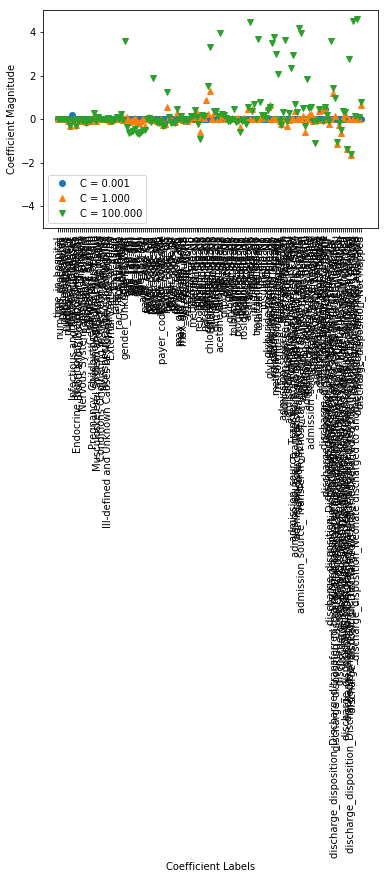

In [142]:
for C, marker in zip([0.001, 1.0, 100.0], ['o','^','v']):
    lr_l1 = LogisticRegression(C = C, penalty = 'l1').fit(X_train, y_train)
    print('Training accuracy of l1 logreg with C = {:.3f}: {:.5f}'.format(C, lr_l1.score(X_train, y_train)))
    print('Test accuracy of l1 logreg with C = {:.3f}: {:.5f}'.format(C, lr_l1.score(X_test, y_test)))
    
    plt.plot(lr_l1.coef_.T, marker, label = 'C = {:.3f}'.format(C))

plt.xticks(range(df[feature_cols].shape[1]), df[feature_cols].columns.values, rotation = 90)
plt.hlines(0,0,df[feature_cols].shape[1])
plt.xlabel('Coefficient Labels')
plt.ylabel('Coefficient Magnitude')

plt.ylim(-5,5)
plt.legend(loc = 3)


In [128]:
logreg_1 = LogisticRegression(C = 1.0)
X = df[feature_cols]
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y
                                                    ,test_size = 0.20
                                                    ,random_state = 5)

In [129]:
logreg_1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [130]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistc regression classifiers on training set: {:.3f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistc regression classifiers on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistc regression classifiers on training set: 0.910
Accuracy of logistc regression classifiers on test set: 0.911


In [117]:
for a,b in zip(feature_cols,logreg.coef_[0]):
    print(a,b)

time_in_hospital -0.0132191345214
num_lab_procedures -0.00182689682831
num_procedures 0.00148442321132
num_medications 0.000206262500177
number_outpatient -0.00222957908646
number_emergency -0.0823361576098
number_inpatient -0.333758978667
number_diagnoses -0.0378575076881
Infectious and Parasitic Diseases -0.0204638940457
Neoplasms -0.298610168046
Endocrine, Nutritional, Metabolic, Immunity -0.0943869165714
Blood and Blood-Forming Organs 0.0181253042833
Mental Disorders -0.0770232270915
Nervous System and Sense Organs -0.0361313398509
Circulatory System -0.157629911802
Respiratory System -0.00963967002603
Digestive System -0.0971359975371
Genitourinary System 0.00719174979674
Pregnancy, Childbirth, and the Puerperium 0.249698346336
Skin and Subcutaneous Tissue -0.0943385772665
Musculoskeletal System and Connective Tissue 0.101553403928
Congenital Anomalies -0.0010526855519
Conditions Originating in the Perinatal Period 0.0
Symptoms 0.0232783767753
Nonspecific Abnormal Findings -0.0414

In [119]:
confMat = confusion_matrix(y_test,y_pred)

In [120]:
print(confMat)

[[    3  1243]
 [    7 12745]]


In [122]:
classRep = classification_report(y_test, y_pred)

In [123]:
print(classRep)

             precision    recall  f1-score   support

        <30       0.30      0.00      0.00      1246
         NO       0.91      1.00      0.95     12752

avg / total       0.86      0.91      0.87     13998



In [ ]:
hot = df[['vol_k', 'activation']]

cat_vars = list(df.select_dtypes(include=['category']).columns)
for var in cat_vars:
    new = pd.get_dummies(df[var])
    hot = hot.join(new)
    
    #drop most frequent variable for ref category
    drop_col = df.groupby([var]).size().idxmax()
    hot.drop(drop_col, axis=1, inplace=True)
  
    print(var + " dropping " + drop_col)
    print(df.groupby([var]).size())`

In [ ]:
drug features = the feature indicates whether the drug was prescribed or there was a change in the 
dosage. Values: 
“up” if the dosage was increased during the encounter, 
“down” if the dosage was decreased, 
“steady” if the dosage did not change, 
“no” if the drug was not prescribed

In [ ]:
get dummies ensure k -1 considered for each column that gets dummied
designate categorical columns
get count of unique values in categorical columns
review numerical nominal distinctions in paper


In [ ]:
http://www.algosome.com/articles/dummy-variable-trap-regression.html
    
a scenario in which two or more variables are highly correlated; in simple terms one variable can be predicted from the others. 

In [ ]:
http://www.tdrdata.com/ipd/ipd_SearchForICD9CodesAndDescriptions
    
001 - 139 	Infectious and Parasitic Diseases
140 - 239 	Neoplasms
240 - 279 	Endocrine, Nutritional, Metabolic, Immunity
280 - 289 	Blood and Blood-Forming Organs
290 - 319 	Mental Disorders
320 - 389 	Nervous System and Sense Organs
390 - 459 	Circulatory System
460 - 519 	Respiratory System
520 - 579 	Digestive System
580 - 629 	Genitourinary System
630 - 677 	Pregnancy, Childbirth, and the Puerperium
680 - 709 	Skin and Subcutaneous Tissue
710 - 739 	Musculoskeletal System and Connective Tissue
740 - 759 	Congenital Anomalies
760 - 779 	Conditions Originating in the Perinatal Period
780 - 789 	Symptoms
790 - 796 	Nonspecific Abnormal Findings
797 - 799 	Ill-defined and Unknown Causes of Morbidity and Mortality
800 - 999 	Injury and Poisoning
V Codes 	Supplemental V-Codes
Ref Codes 	Reference Codes 